In [1]:
%matplotlib inline


.. currentmodule:: dgl

Graph Classification Tutorial
=============================

**Author**: `Mufei Li <https://github.com/mufeili>`_,
`Minjie Wang <https://jermainewang.github.io/>`_,
`Zheng Zhang <https://shanghai.nyu.edu/academics/faculty/directory/zheng-zhang>`_.

In this tutorial, you learn how to use DGL to batch multiple graphs of variable size and shape. The 
tutorial also demonstrates training a graph neural network for a simple graph classification task.

Graph classification is an important problem
with applications across many fields, such as bioinformatics, chemoinformatics, social
network analysis, urban computing, and cybersecurity. Applying graph neural
networks to this problem has been a popular approach recently. This can be seen in the following reserach references: 
`Ying et al., 2018 <https://arxiv.org/abs/1806.08804>`_,
`Cangea et al., 2018 <https://arxiv.org/abs/1811.01287>`_,
`Knyazev et al., 2018 <https://arxiv.org/abs/1811.09595>`_,
`Bianchi et al., 2019 <https://arxiv.org/abs/1901.01343>`_,
`Liao et al., 2019 <https://arxiv.org/abs/1901.01484>`_,
`Gao et al., 2019 <https://openreview.net/forum?id=HJePRoAct7>`_).


Simple graph classification task
--------------------------------
In this tutorial, you learn how to perform batched graph classification
with DGL. The example task objective is to classify eight types of topologies shown here.

![](https://data.dgl.ai/tutorial/batch/dataset_overview.png)

    :align: center

Implement a synthetic dataset :class:`data.MiniGCDataset` in DGL. The dataset has eight 
different types of graphs and each class has the same number of graph samples.



Using backend: pytorch
/home/mateusz/Programs/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/mateusz/Programs/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


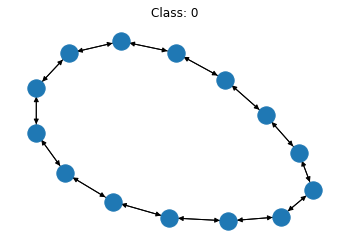

In [4]:
from dgl.data import MiniGCDataset
import matplotlib.pyplot as plt
import networkx as nx
# A dataset with 80 samples, each graph is
# of size [10, 20]
dataset = MiniGCDataset(80, 10, 20)
graph, label = dataset[0]
fig, ax = plt.subplots()
nx.draw(graph.to_networkx(), ax=ax)
ax.set_title('Class: {:d}'.format(label))
plt.show()

Form a graph mini-batch
-----------------------
To train neural networks efficiently, a common practice is to batch
multiple samples together to form a mini-batch. Batching fixed-shaped tensor
inputs is common. For example, batching two images of size 28 x 28
gives a tensor of shape 2 x 28 x 28. By contrast, batching graph inputs
has two challenges:

* Graphs are sparse.
* Graphs can have various length. For example, number of nodes and edges.

To address this, DGL provides a :func:`dgl.batch` API. It leverages the idea that
a batch of graphs can be viewed as a large graph that has many disjointed 
connected components. Below is a visualization that gives the general idea.

![](https://data.dgl.ai/tutorial/batch/batch.png)

    :width: 400pt
    :align: center

Define the following ``collate`` function to form a mini-batch from a given
list of graph and label pairs.



In [5]:
import dgl
import torch

def collate(samples):
    # The input `samples` is a list of pairs
    #  (graph, label).
    graphs, labels = map(list, zip(*samples))
    batched_graph = dgl.batch(graphs)
    return batched_graph, torch.tensor(labels)

The return type of :func:`dgl.batch` is still a graph. In the same way, 
a batch of tensors is still a tensor. This means that any code that works
for one graph immediately works for a batch of graphs. More importantly,
because DGL processes messages on all nodes and edges in parallel, this greatly
improves efficiency.

Graph classifier
----------------
Graph classification proceeds as follows.

![](https://data.dgl.ai/tutorial/batch/graph_classifier.png)


From a batch of graphs, perform message passing and graph convolution
for nodes to communicate with others. After message passing, compute a
tensor for graph representation from node (and edge) attributes. This step might 
be called readout or aggregation. Finally, the graph 
representations are fed into a classifier $g$ to predict the graph labels.

Graph convolution layer can be found in the ``dgl.nn.<backend>`` submodule.



In [6]:
from dgl.nn.pytorch import GraphConv

Readout and classification
--------------------------
For this demonstration, consider initial node features to be their degrees.
After two rounds of graph convolution, perform a graph readout by averaging
over all node features for each graph in the batch.

\begin{align}h_g=\frac{1}{|\mathcal{V}|}\sum_{v\in\mathcal{V}}h_{v}\end{align}

In DGL, :func:`dgl.mean_nodes` handles this task for a batch of
graphs with variable size. You then feed the graph representations into a
classifier with one linear layer to obtain pre-softmax logits.



In [7]:
import torch.nn as nn
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_classes):
        super(Classifier, self).__init__()
        self.conv1 = GraphConv(in_dim, hidden_dim)
        self.conv2 = GraphConv(hidden_dim, hidden_dim)
        self.classify = nn.Linear(hidden_dim, n_classes)

    def forward(self, g):
        # Use node degree as the initial node feature. For undirected graphs, the in-degree
        # is the same as the out_degree.
        h = g.in_degrees().view(-1, 1).float()
        # Perform graph convolution and activation function.
        h = F.relu(self.conv1(g, h))
        h = F.relu(self.conv2(g, h))
        g.ndata['h'] = h
        # Calculate graph representation by averaging all the node representations.
        hg = dgl.mean_nodes(g, 'h')
        return self.classify(hg)

Setup and training
------------------
Create a synthetic dataset of $400$ graphs with $10$ ~
$20$ nodes. $320$ graphs constitute a training set and
$80$ graphs constitute a test set.



In [8]:
import torch.optim as optim
from torch.utils.data import DataLoader

# Create training and test sets.
trainset = MiniGCDataset(320, 10, 20)
testset = MiniGCDataset(80, 10, 20)
# Use PyTorch's DataLoader and the collate function
# defined before.
data_loader = DataLoader(trainset, batch_size=32, shuffle=True,
                         collate_fn=collate)

# Create model
model = Classifier(1, 256, trainset.num_classes)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.train()

epoch_losses = []
for epoch in range(80):
    epoch_loss = 0
    for iter, (bg, label) in enumerate(data_loader):
        prediction = model(bg)
        loss = loss_func(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach().item()
    epoch_loss /= (iter + 1)
    print('Epoch {}, loss {:.4f}'.format(epoch, epoch_loss))
    epoch_losses.append(epoch_loss)

Epoch 0, loss 2.0030
Epoch 1, loss 1.9560
Epoch 2, loss 1.9501
Epoch 3, loss 1.9359
Epoch 4, loss 1.9301
Epoch 5, loss 1.9133
Epoch 6, loss 1.9006
Epoch 7, loss 1.8836
Epoch 8, loss 1.8540
Epoch 9, loss 1.8215
Epoch 10, loss 1.7827
Epoch 11, loss 1.7344
Epoch 12, loss 1.6758
Epoch 13, loss 1.6198
Epoch 14, loss 1.5604
Epoch 15, loss 1.4995
Epoch 16, loss 1.4402
Epoch 17, loss 1.3853
Epoch 18, loss 1.3170
Epoch 19, loss 1.2675
Epoch 20, loss 1.2125
Epoch 21, loss 1.1725
Epoch 22, loss 1.1281
Epoch 23, loss 1.0780
Epoch 24, loss 1.0479
Epoch 25, loss 1.0198
Epoch 26, loss 0.9872
Epoch 27, loss 0.9661
Epoch 28, loss 0.9540
Epoch 29, loss 0.9425
Epoch 30, loss 0.9382
Epoch 31, loss 0.8970
Epoch 32, loss 0.8833
Epoch 33, loss 0.8705
Epoch 34, loss 0.8627
Epoch 35, loss 0.8463
Epoch 36, loss 0.8320
Epoch 37, loss 0.8260
Epoch 38, loss 0.8237
Epoch 39, loss 0.8107
Epoch 40, loss 0.8053
Epoch 41, loss 0.8042
Epoch 42, loss 0.7838
Epoch 43, loss 0.8041
Epoch 44, loss 0.7946
Epoch 45, loss 0.791

The learning curve of a run is presented below.



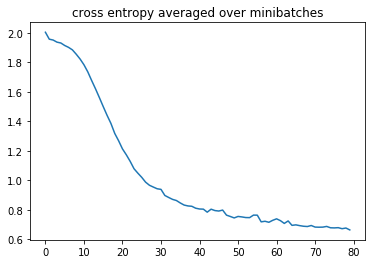

In [9]:
plt.title('cross entropy averaged over minibatches')
plt.plot(epoch_losses)
plt.show()

The trained model is evaluated on the test set created. To deploy
the tutorial, restrict the running time to get a higher
accuracy ($80$ % ~ $90$ %) than the ones printed below.



In [10]:
model.eval()
# Convert a list of tuples to two lists
test_X, test_Y = map(list, zip(*testset))
test_bg = dgl.batch(test_X)
test_Y = torch.tensor(test_Y).float().view(-1, 1)
probs_Y = torch.softmax(model(test_bg), 1)
sampled_Y = torch.multinomial(probs_Y, 1)
argmax_Y = torch.max(probs_Y, 1)[1].view(-1, 1)
print('Accuracy of sampled predictions on the test set: {:.4f}%'.format(
    (test_Y == sampled_Y.float()).sum().item() / len(test_Y) * 100))
print('Accuracy of argmax predictions on the test set: {:4f}%'.format(
    (test_Y == argmax_Y.float()).sum().item() / len(test_Y) * 100))

Accuracy of sampled predictions on the test set: 65.0000%
Accuracy of argmax predictions on the test set: 71.250000%


The animation here plots the probability that a trained model predicts the correct graph type.

![](https://data.dgl.ai/tutorial/batch/test_eval4.gif)


To understand the node and graph representations that a trained model learned,
we use `t-SNE, <https://lvdmaaten.github.io/tsne/>`_ for dimensionality reduction
and visualization.

![](https://data.dgl.ai/tutorial/batch/tsne_node2.png)

    :align: center

![](https://data.dgl.ai/tutorial/batch/tsne_graph2.png)

    :align: center

The two small figures on the top separately visualize node representations after one and two
layers of graph convolution. The figure on the bottom visualizes
the pre-softmax logits for graphs as graph representations.

While the visualization does suggest some clustering effects of the node features,
you would not expect a perfect result. Node degrees are deterministic for
these node features. The graph features are improved when separated.

What's next?
------------
Graph classification with graph neural networks is still a new field.
It's waiting for people to bring more exciting discoveries. The work requires 
mapping different graphs to different embeddings, while preserving
their structural similarity in the embedding space. To learn more about it, see 
`How Powerful Are Graph Neural Networks? <https://arxiv.org/abs/1810.00826>`_ a research paper  
published for the International Conference on Learning Representations 2019.

For more examples about batched graph processing, see the following:

* Tutorials for `Tree LSTM <https://docs.dgl.ai/tutorials/models/2_small_graph/3_tree-lstm.html>`_ and `Deep Generative Models of Graphs <https://docs.dgl.ai/tutorials/models/3_generative_model/5_dgmg.html>`_
* An example implementation of `Junction Tree VAE <https://github.com/dmlc/dgl/tree/master/examples/pytorch/jtnn>`_

